In [23]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pyro
import numpy as np
import pylab as pl
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO, Predictive

sns.set_style("whitegrid")

from scripts import *
from models import *

In [24]:
data = pd.read_csv("../Datasets/Avocado_prices_2020/avocado-updated-2020.csv", sep=",")

In [25]:
data.describe()

,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,year
count,33045.000000,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,3.304500e+04,33045.000000
mean,1.379941,9.683997e+05,3.023914e+05,2.797693e+05,2.148255e+04,3.646735e+05,2.501980e+05,1.067329e+05,7.742585e+03,2017.460887
std,0.378972,3.934533e+06,1.301026e+06,1.151052e+06,1.001607e+05,1.564004e+06,1.037734e+06,5.167226e+05,4.819803e+04,1.699747
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.000000
25%,1.100000,1.511895e+04,7.673100e+02,2.712470e+03,0.000000e+00,9.121860e+03,6.478630e+03,4.662900e+02,0.000000e+00,2016.000000
50%,1.350000,1.291170e+05,1.099477e+04,2.343600e+04,1.780900e+02,5.322224e+04,3.687699e+04,6.375860e+03,0.000000e+00,2017.000000
75%,1.620000,5.058285e+05,1.190219e+05,1.352389e+05,5.096530e+03,1.744314e+05,1.206624e+05,4.041723e+04,8.044400e+02,2019.000000
max,3.250000,6.371614e+07,2.274362e+07,2.047057e+07,2.546439e+06,3.168919e+07,2.055041e+07,1.332760e+07,1.403184e+06,2020.000000


In [26]:
# Check null values
data.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

In [27]:
# Convert date to datetime format
data["date"] = pd.to_datetime(data["date"])

In [28]:
# Sort data by date
data = data.sort_values(["date"], ascending=[True]) 

In [29]:
# Consider data of the whole US
avocado_us = data[data["geography"]=="Total U.S."]

In [30]:
class avocado_colors():
    def __init__(self):
        # self.colors = ["#356211", "#558303", "#6c8f32", "#f2e880", "#c15c37", "#aa471f"]
        # self.colors = ["#4a7337", "#6b8c21", "#ddd48f", "#cda989", "#704012"]
        self.colors = ["#4a7337", "#6b8c21", "#704012"]
        # self.colors = ["#4a7337", "#d89465", "#704012"]
        self.colors = ["19382d", "#8b915b", "#5c1924"]
        self.i = -1

    def __getitem__(self, idx):
        return self.colors[idx]
    
    def __call__(self):
        self.i = (self.i + 1) % len(self.colors)
        return self.colors[self.i]

    def test_colors(self):
        for i in range(len(self.colors)):
            pl.plot(np.random.normal(0,1,1000).cumsum(), color=self.colors[i])

colors = avocado_colors()

def moving_average(x, w=21):
    return np.convolve(x, np.ones(w), 'same') / w

def plot_series(data, legend=None, w=1):
    i = 0
    for column in data:
        if column != "date":
            x = pd.to_datetime(data["date"])
            y = moving_average(data[column], w)
            label = column if legend is None else legend[i]
            pl.plot_date(x, y, "-", label=label, color=colors())
            i += 1
    pl.legend()
    pl.xlabel("Date")

def sum_columns(data, columns, name):
    data[name] = data[columns].sum(axis=1)


Text(0.5, 1.0, 'Avocados sold by type')

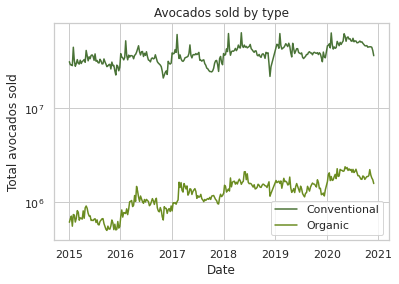

In [32]:
# Total avocados sold over time
plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "total_volume"]], legend=["Conventional"])
plot_series(avocado_us[avocado_us["type"]=="organic"][["date", "total_volume"]], legend=["Organic"])
pl.yscale("log")
pl.ylabel("Total avocados sold")
pl.title("Avocados sold by type")

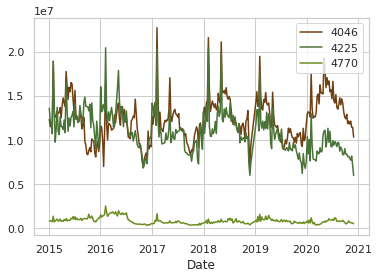

In [33]:
# Avocados sold by type over time
plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "4046", "4225", "4770"]])

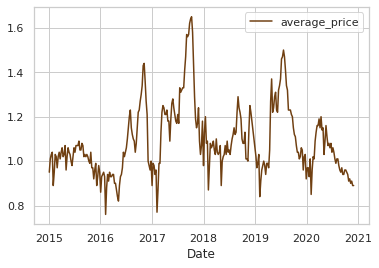

In [34]:
# Avocado price over time
plot_series(avocado_us[avocado_us["type"]=="conventional"][["date", "average_price"]])

It seems that the Avocadopocalypse of 2017 was indeed real, the price grew to over 1.6$, a 50% increase from its mean of 1.08$

In [38]:
# Region by avocado sales
avocados_growth = pd.DataFrame(columns = set(data["geography"]))

for column in avocados_growth:
    region = data[(data["geography"]==column) & (data["type"]=="conventional")]
    avocados_per_year = region.groupby(region["date"].dt.year)["total_volume"].mean().to_numpy()
    avocados_growth[column] = avocados_per_year[1:] / avocados_per_year[:-1]

avocados_growth["year"] = np.sort(list(set(data["year"])))[1:]
avocados_growth = avocados_growth.set_index("year")

In [39]:
avocados_growth

,Harrisburg/Scranton,Detroit,Charlotte,Total U.S.,Southeast,Chicago,West Tex/New Mexico,Richmond/Norfolk,Denver,Los Angeles,...,Sacramento,Syracuse,Spokane,Atlanta,New York,Las Vegas,Jacksonville,Orlando,Dallas/Ft. Worth,Great Lakes
year,,,,,,,,,,,,,,,,,,,,,
2016,2.413377,1.975998,1.740828,1.456681,1.849316,1.390129,1.970026,1.433201,1.057930,2.114622,...,0.763949,1.512076,0.900223,1.714408,2.040474,1.404580,1.661839,1.884076,2.124840,1.553359
2017,1.946883,1.161985,1.385301,1.262510,1.338827,1.210269,0.992147,1.437795,0.910855,0.993086,...,0.903945,1.808706,1.245006,1.444069,2.496496,1.044600,0.979099,1.074933,0.962952,1.371502
2018,1.286008,1.488384,1.482016,1.310394,1.572953,1.128731,1.305471,1.632368,1.100481,1.110141,...,1.655487,1.697117,1.420614,1.242173,1.244191,1.188886,1.368875,1.741693,1.229389,1.346027
2019,0.905587,0.738446,1.012671,0.941607,0.861557,1.260544,0.815276,0.988564,0.755045,0.979961,...,1.226843,0.743059,0.922547,1.224558,0.870506,0.931574,0.667202,0.577101,1.035671,0.934300
2020,1.067525,1.299671,1.338922,1.359572,1.428329,1.410749,1.505395,1.110191,2.026229,1.671875,...,1.529286,0.871205,1.448358,1.524735,1.137054,1.329096,1.434210,1.680325,1.595688,1.256184


Text(0.5, 1.0, 'Growth of avocado sales by year')

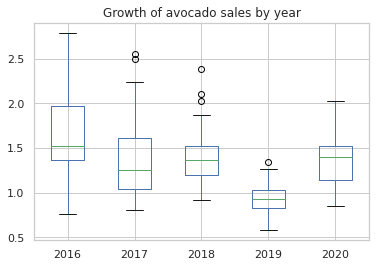

In [40]:
avocados_growth.T.plot.box()
pl.title("Growth of avocado sales by year")

## Predicitions

We start by considering 1-week ahead prediction of the total volume of avocados across the US